# VGGIsh Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender
- Includes visualisations & analysis

The dataset is highly unbalanced.

In [249]:
# Standard imports
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, L1L2

# Optuna import
import optuna

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical tests
from scipy.stats import levene

from IPython.display import display
import time

In [250]:
# Track running time (including analysis)
start_time = time.time()

In [251]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


#### TOTAL RESULTS ACROSS SEED INITIATION

In [252]:
# Lists to collect statistics across all CVs
all_losses, all_accuracies, all_precisions, all_recalls, all_f1 = [], [], [], [], []
average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1 = [], [], [], [], []
all_majority_vote_accuracies, all_majority_vote_details, all_class_stats, all_gender_stats  = [], [], [], []

# training accuracies
all_best_training_acc = []
total_training_acc = []

## Define Functions

In [253]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [254]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [255]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [256]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "multi-seed-val-D13.txt" 

In [257]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

In [258]:
def styled_barplot_with_average(data, x, y, title, xlabel, ylabel, average_line=None):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 
    
    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")
    
    if average_line is not None:
        plt.axhline(y=average_line, color='red', linestyle='--', 
                    label=f'Macro-Averaged Accuracy: {average_line:.1f}%')
        plt.legend(fontsize=10)
    
    plt.show()

In [259]:
def plot_all_metrics(losses, accuracies, precisions, recalls, f1, metrics_across, x_axis_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    seeds = range(1, len(losses) + 1)

    ax.plot(seeds, losses, marker='o', color='blue', label='Loss')
    ax.plot(seeds, accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(seeds, precisions, marker='o', color='red', label='Precision')
    ax.plot(seeds, recalls, marker='o', color='purple', label='Recall')
    ax.plot(seeds, f1, marker='o', color='orange', label='F1 Score')

    ax.set_title(f'Metrics Across {metrics_across}')
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Metric Value')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True)

    return fig

In [260]:
# store epoch accs
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

# RANDOM SEED 1

## Prepare Data

In [261]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')



def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [262]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [263]:
tf.keras.backend.clear_session()

## Run Setup

In [264]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # Apply SMOTE to the training data only
    smote = SMOTE()
    X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1


Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
000B    19
029A    17
019A    17
101A    15
042A    14
001A    14
097B    14
106A    14
059A    14
002A    13
111A    13
028A    13
051A    12
063A    11
025A    11
071A    10
005A    10
016A    10
072A     9
065A     9
045A     9
033A     9
015A     9
010A     8
095A     8
094A     8
050A     7
117A     7
027A     7
031A     7
108A     6
007A     6
037A     6
021A     5
023B     5
025C     5
075A     5
070A     5
034A     5
044A     5
052A     4
035A     4
026A     4
105A     4
003A     4
009A     4
012A     3
064A     3
058A     3
006A     3
056A     3
113A     3
014A     3
038A     2
054A     2
032A     2
093A     2
069A     2
018A     2
025B     2
087A     2
102A     2
004A     1
090A     1
100A     1
115A     1
091A     1
019B     1
073A     1
048A     1
066A     1
096A     1
043A     1
026C     1
041A     1
092A     1
076A     1
026B     1
Name: cat_id, dtype: int

Epoch 1/1500
8/8 [==============================] - 0s 1ms/step - loss: 1.3424 - accuracy: 0.4544
Epoch 2/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.9300 - accuracy: 0.6034
Epoch 3/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.8490 - accuracy: 0.6602
Epoch 4/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7747 - accuracy: 0.7063
Epoch 5/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7716 - accuracy: 0.7095
Epoch 6/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7473 - accuracy: 0.7128
Epoch 7/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7453 - accuracy: 0.7042
Epoch 8/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6897 - accuracy: 0.7331
Epoch 9/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6667 - accuracy: 0.7203
Epoch 10/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6270 - accuracy: 0.7492
Epoch 11/1500
8/8 [

Majority Vote Accuracy for cat_id for this fold: 0.72 (21/29)
Before appending - Cat IDs: 197, Predictions: 197, Actuals: 197, Gender: 197
After appending - Cat IDs: 444, Predictions: 444, Actuals: 444, Gender: 444
Final Test Results - Loss: 0.6337435245513916, Accuracy: 0.7327935099601746, Precision: 0.7069310344827585, Recall: 0.7372598935431612, F1 Score: 0.7114852175259928
Confusion Matrix:
 [[104   5  40]
 [  5  53   0]
 [ 16   0  24]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
002B    32
057A    27
074A    25
020A    23
055A    20
067A    19
019A    17
097A    16
042A    14
097B    14
059A    14
028A    13
002A    13
111A    13
039A    12
116A    12
051A    12
036A    11
025A    11
063A    11
068A    11
005A    10
040A    10
014B    10
051B     9
022A     9
065A     9
015A     9
045A     9
010A     8
013B     8
050A     7
027A     7
099A     7
008A     6
109A     6
007A     6
053A     6
023A     6
108A     6
023B     5
021A     5
070A     5
025C     5
035A  

Epoch 1/1500
9/9 [==============================] - 0s 1ms/step - loss: 1.2279 - accuracy: 0.5175
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.8607 - accuracy: 0.6501
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.7275 - accuracy: 0.7109
Epoch 4/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6761 - accuracy: 0.7376
Epoch 5/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6198 - accuracy: 0.7698
Epoch 6/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6155 - accuracy: 0.7532
Epoch 7/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5763 - accuracy: 0.7790
Epoch 8/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5801 - accuracy: 0.7956
Epoch 9/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5528 - accuracy: 0.7882
Epoch 10/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5223 - accuracy: 0.8085
Epoch 11/1500
9/9 [

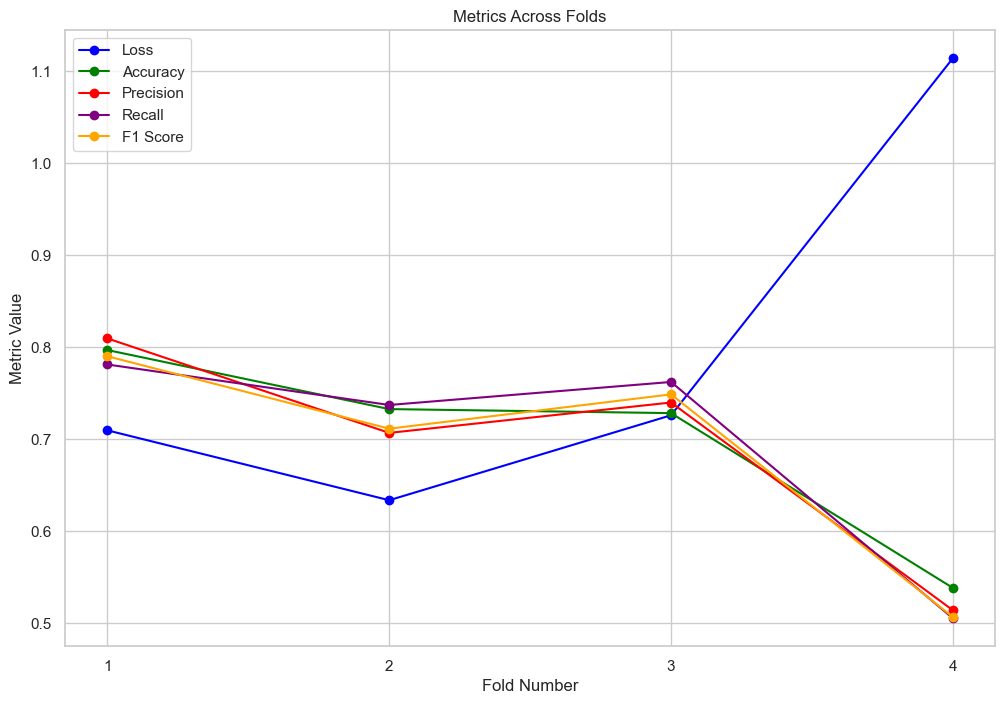

In [265]:
seed_1_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_1_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_1_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [266]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 869, Predictions: 869, Actuals: 869, Gender: 869


In [267]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [268]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.73 (80/110)


In [269]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [270]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, kitten, adult, senior, adult, adult, ...",adult,adult,True
62,056A,"[senior, senior, senior]",senior,senior,True
78,072A,"[adult, kitten, adult, adult, adult, adult, ad...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[adult, adult, senior, adult, adult, adult, se...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,065A,"[senior, senior, adult, adult, adult, senior, ...",adult,adult,True
70,064A,"[adult, adult, adult]",adult,adult,True
68,062A,"[kitten, adult, adult, adult]",adult,adult,True


In [271]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  75.409836           61
1           kitten  80.000000           15
2           senior  64.705882           34


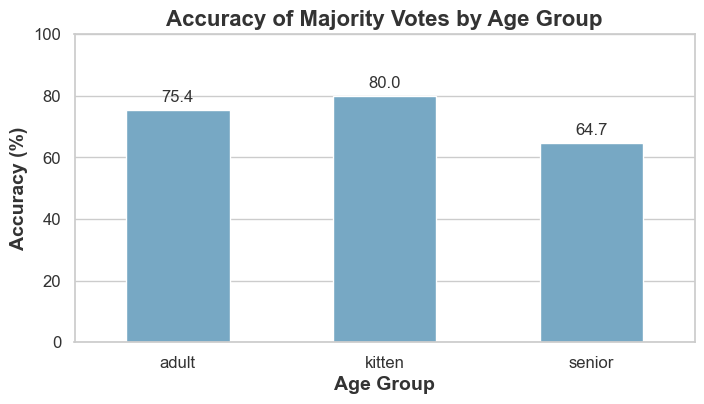

In [272]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [273]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  69.555035          427
1           kitten  80.882353          136
2           senior  67.320261          306


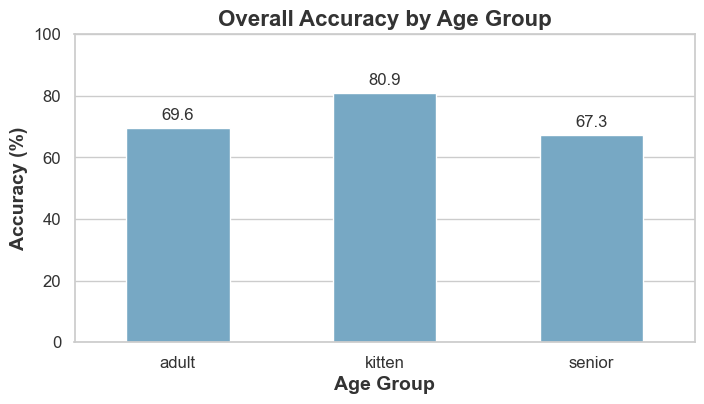

In [274]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [275]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      157     73.71
1          M    337      220     65.28
2          X    319      236     73.98


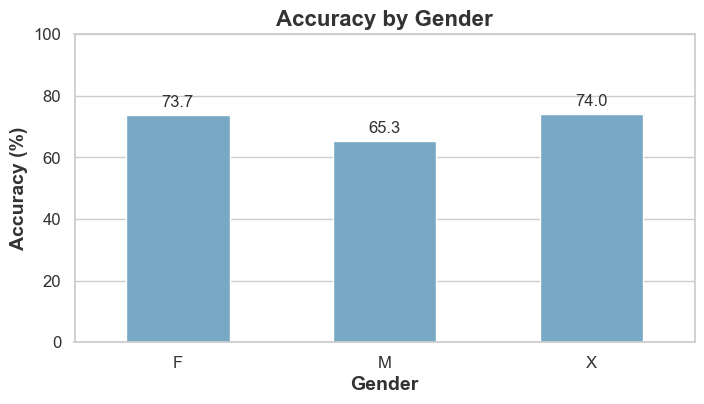

In [276]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [277]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7272727272727273]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.555035          427
1           kitten  80.882353          136
2           senior  67.320261          306]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    213      157     73.71
1          M    337      220     65.28
2          X    319      236     73.98]


# RANDOM SEED 2

In [278]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1]))
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')



def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [279]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [280]:
tf.keras.backend.clear_session()

## Run Setup

In [281]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # Apply SMOTE to the training data only
    smote = SMOTE()
    X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
057A    27
074A    25
020A    23
055A    20
067A    19
000B    19
029A    17
019A    17
101A    15
042A    14
059A    14
097B    14
001A    14
028A    13
111A    13
002A    13
039A    12
051A    12
116A    12
025A    11
036A    11
040A    10
016A    10
071A    10
005A    10
014B    10
051B     9
072A     9
065A     9
010A     8
095A     8
013B     8
094A     8
050A     7
027A     7
109A     6
023A     6
007A     6
108A     6
008A     6
021A     5
070A     5
025C     5
075A     5
023B     5
044A     5
034A     5
035A     4
003A     4
062A     4
009A     4
052A     4
104A     4
012A     3
064A     3
058A     3
006A     3
056A     3
113A     3
060A     3
014A     3
025B     2
061A     2
102A     2
087A     2
038A     2
093A     2
054A     2
032A     2
069A     2
092A     1
024A     1
090A     1
091A     1
115A     1
019B     1
041A     1
004A     1
076A     1
026C     1
073A     1
026B     1
Name: cat_i

Epoch 1/1500
8/8 [==============================] - 0s 2ms/step - loss: 1.2133 - accuracy: 0.5196
Epoch 2/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.9045 - accuracy: 0.6500
Epoch 3/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.8242 - accuracy: 0.6667
Epoch 4/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7808 - accuracy: 0.6735
Epoch 5/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7531 - accuracy: 0.7029
Epoch 6/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7260 - accuracy: 0.7186
Epoch 7/1500
8/8 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.7029
Epoch 8/1500
8/8 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.7216
Epoch 9/1500
8/8 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.7490
Epoch 10/1500
8/8 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.7578
Epoch 11/1500
8/8 [

Moved to Training/Validation Set:
set()
Removed from Training/Validation Set:
set()
Moved to Test Set:
set()
Removed from Test Set
set()
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '003A' '004A' '006A' '007A' '009A' '011A'
 '012A' '014A' '014B' '015A' '016A' '018A' '019A' '019B' '020A' '021A'
 '022A' '023A' '023B' '024A' '025A' '025B' '025C' '026A' '027A' '028A'
 '031A' '032A' '033A' '035A' '036A' '037A' '039A' '040A' '041A' '043A'
 '044A' '045A' '046A' '047A' '048A' '049A' '051B' '052A' '053A' '054A'
 '055A' '057A' '059A' '061A' '062A' '063A' '064A' '065A' '066A' '067A'
 '068A' '070A' '071A' '072A' '073A' '074A' '087A' '088A' '090A' '091A'
 '092A' '094A' '096A' '097A' '097B' '099A' '100A' '104A' '105A' '106A'
 '110A' '111A' '113A' '117A']
AFTER SWAP - Unique Test Group IDs:
['002B' '005A' '008A' '010A' '013B' '026B' '026C' '029A' '034A' '038A'
 '042A' '050A' '051A' '056A' '058A' '060A' '069A' '075A' '076A' '093A'
 '095A' '101A' '102A' '103A' '108A' 

Epoch 1/1500
8/8 [==============================] - 0s 1ms/step - loss: 1.1921 - accuracy: 0.5545
Epoch 2/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.8346 - accuracy: 0.6595
Epoch 3/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.8130 - accuracy: 0.6821
Epoch 4/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.7487 - accuracy: 0.6893
Epoch 5/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.6558 - accuracy: 0.7305
Epoch 6/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6467 - accuracy: 0.7366
Epoch 7/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6048 - accuracy: 0.7726
Epoch 8/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.5520 - accuracy: 0.7778
Epoch 9/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.5915 - accuracy: 0.7531
Epoch 10/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.7860
Epoch 11/1500
8/8 [

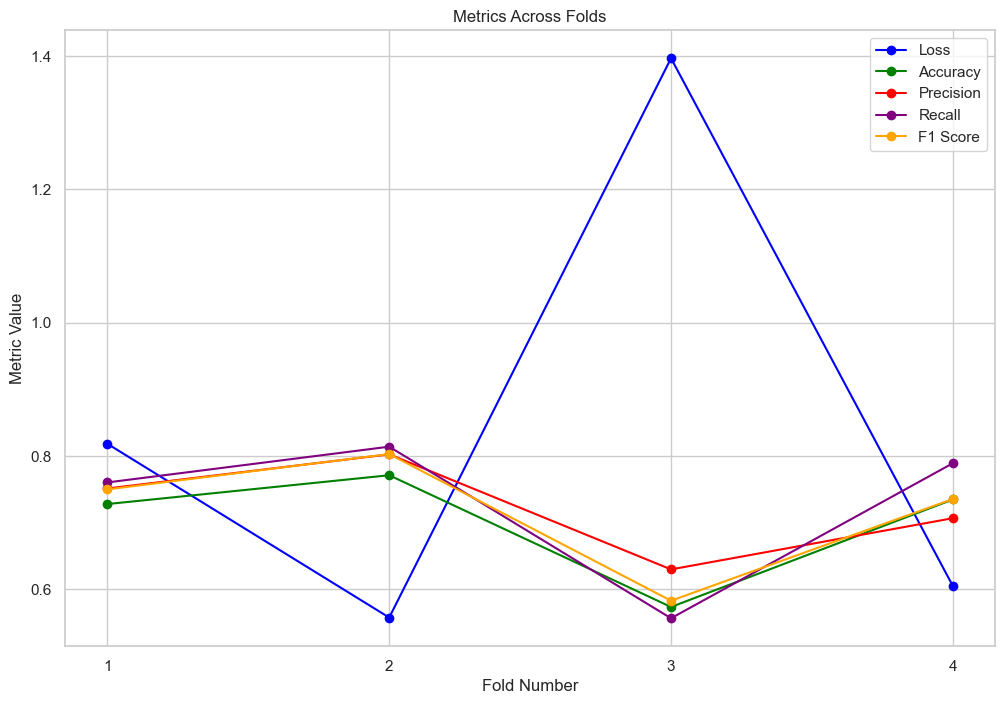

In [282]:
seed_2_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_2_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_2_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [283]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 853, Predictions: 853, Actuals: 853, Gender: 853


In [284]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [285]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.74 (81/110)


In [286]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [287]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, kitten, adult, senior, adult, adult, ...",adult,adult,True
61,055A,"[senior, adult, senior, senior, senior, senior...",senior,senior,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, senior, adult, adult, adult]",adult,adult,True
75,069A,"[adult, senior]",adult,adult,True
73,067A,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
71,065A,"[adult, adult, adult, adult, adult, senior, ki...",adult,adult,True
68,062A,"[adult, adult, adult, adult]",adult,adult,True
65,059A,"[senior, senior, senior, senior, senior, senio...",senior,senior,True
63,057A,"[senior, senior, senior, senior, senior, senio...",senior,senior,True


In [288]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  72.131148           61
1           kitten  93.333333           15
2           senior  67.647059           34


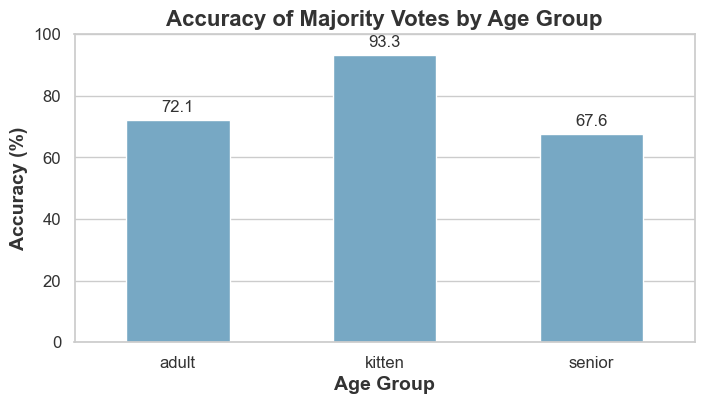

In [289]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [290]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  64.814815          432
1           kitten  81.739130          115
2           senior  72.875817          306


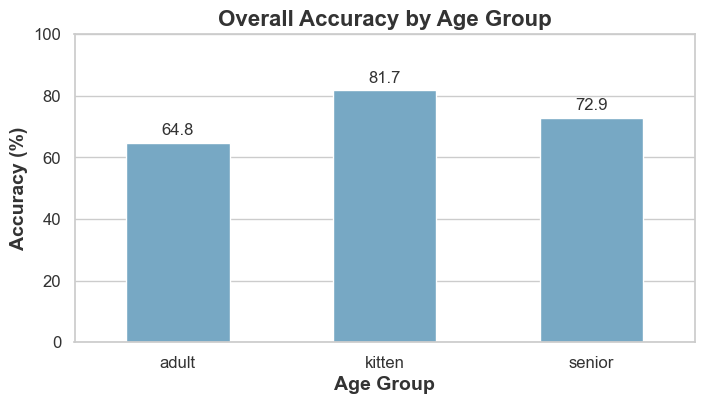

In [291]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [292]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      153     71.83
1          M    337      217     64.39
2          X    303      227     74.92


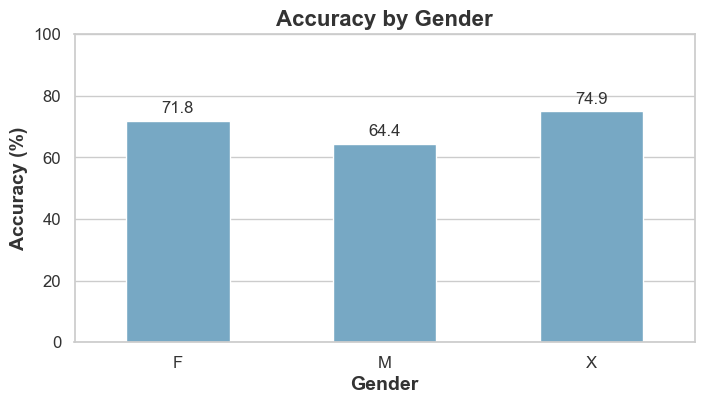

In [293]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [294]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7272727272727273, 0.7363636363636363]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.555035          427
1           kitten  80.882353          136
2           senior  67.320261          306,   actual_age_group   accuracy  total_count
0            adult  64.814815          432
1           kitten  81.739130          115
2           senior  72.875817          306]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    213      157     73.71
1          M    337      220     65.28
2          X    319      236     73.98,   all_gender  count  correct  accuracy
0          F    213      153     71.83
1          M    337      217     64.39
2          X    303      227     74.92]


# RANDOM SEED 3

In [295]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [296]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [297]:
tf.keras.backend.clear_session()

## Run Setup

In [298]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # Apply SMOTE to the training data only
    smote = SMOTE()
    X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
000A    39
002B    32
047A    28
057A    27
074A    25
020A    23
067A    19
019A    17
101A    15
059A    14
001A    14
042A    14
106A    14
002A    13
028A    13
116A    12
039A    12
051A    12
025A    11
063A    11
016A    10
040A    10
071A    10
051B     9
072A     9
065A     9
045A     9
022A     9
095A     8
013B     8
010A     8
099A     7
050A     7
027A     7
108A     6
109A     6
007A     6
053A     6
008A     6
037A     6
023A     6
023B     5
070A     5
025C     5
034A     5
044A     5
052A     4
009A     4
104A     4
035A     4
026A     4
062A     4
064A     3
012A     3
058A     3
006A     3
056A     3
113A     3
014A     3
060A     3
011A     2
102A     2
025B     2
032A     2
018A     2
093A     2
038A     2
069A     2
087A     2
092A     1
088A     1
024A     1
090A     1
100A     1
110A     1
091A     1
004A     1
041A     1
048A     1
066A     1
076A     1
096A     1
043A     1
073A     1
049A     1
026B     1
Name: cat_i

Testing Set Age Group Distribution AFTER SWAP:
adult     116
senior     44
kitten     42
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 344, 2: 262, 1: 129})
Epoch 1/1500
9/9 [==============================] - 0s 1ms/step - loss: 1.2642 - accuracy: 0.5213
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.8524 - accuracy: 0.6550
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.8393 - accuracy: 0.6880
Epoch 4/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.7723 - accuracy: 0.7035
Epoch 5/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.7849 - accuracy: 0.7258
Epoch 6/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.7403
Epoch 7/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.7345
Epoch 8/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6454 - accuracy: 0.7442

Epoch 1/1500
10/10 [==============================] - 0s 2ms/step - loss: 1.2200 - accuracy: 0.5408
Epoch 2/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.8464 - accuracy: 0.6564
Epoch 3/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.7580 - accuracy: 0.6999
Epoch 4/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.7118
Epoch 5/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.5825 - accuracy: 0.7609
Epoch 6/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.6077 - accuracy: 0.7704
Epoch 7/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.5754 - accuracy: 0.7807
Epoch 8/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.5344 - accuracy: 0.8021
Epoch 9/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.5384 - accuracy: 0.7926
Epoch 10/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.5334 - accuracy: 0.7973

Epoch 1/1500
8/8 [==============================] - 0s 1ms/step - loss: 1.2966 - accuracy: 0.5059
Epoch 2/1500
8/8 [==============================] - 0s 1ms/step - loss: 1.0191 - accuracy: 0.6066
Epoch 3/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.8733 - accuracy: 0.6506
Epoch 4/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.8212 - accuracy: 0.6795
Epoch 5/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.8156 - accuracy: 0.7020
Epoch 6/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7955 - accuracy: 0.7031
Epoch 7/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7058 - accuracy: 0.7181
Epoch 8/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6643 - accuracy: 0.7503
Epoch 9/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6467 - accuracy: 0.7428
Epoch 10/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6273 - accuracy: 0.7546
Epoch 11/1500
8/8 [

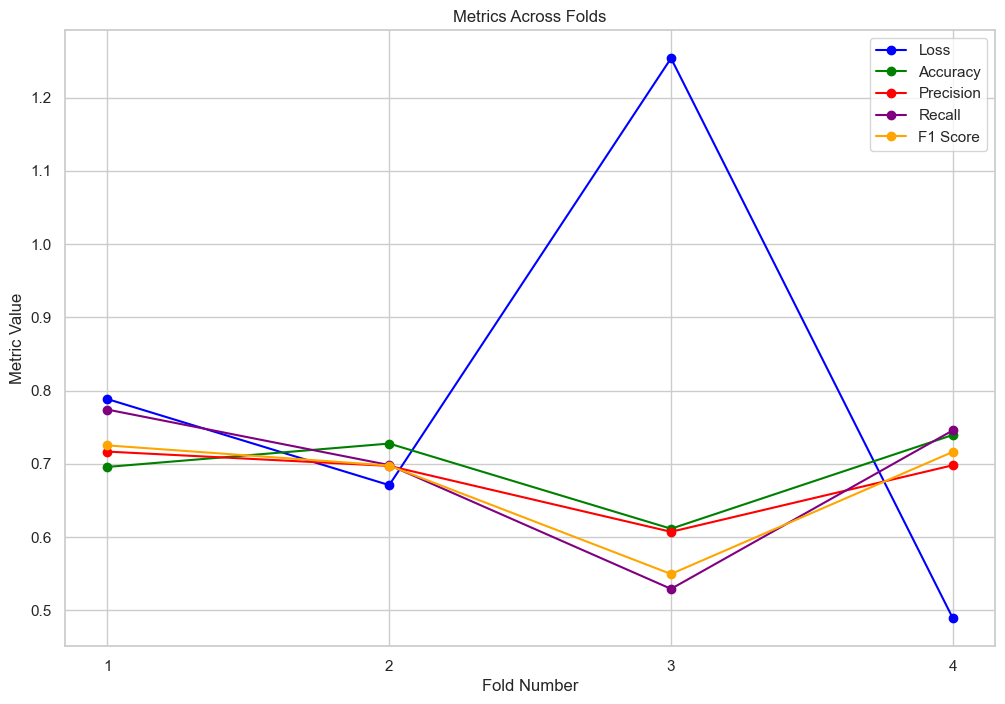

In [299]:
seed_3_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_3_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_3_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [300]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 837, Predictions: 837, Actuals: 837, Gender: 837


In [301]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [302]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.74 (81/110)


In [303]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [304]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, kitten, adult, adult, adult, kitten, ...",adult,adult,True
82,076A,[adult],adult,adult,True
80,074A,"[senior, senior, adult, kitten, adult, adult, ...",adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, kitten, adult, adult, adult, adult, ad...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, senior]",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True


In [305]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  73.770492           61
1           kitten  66.666667           15
2           senior  76.470588           34


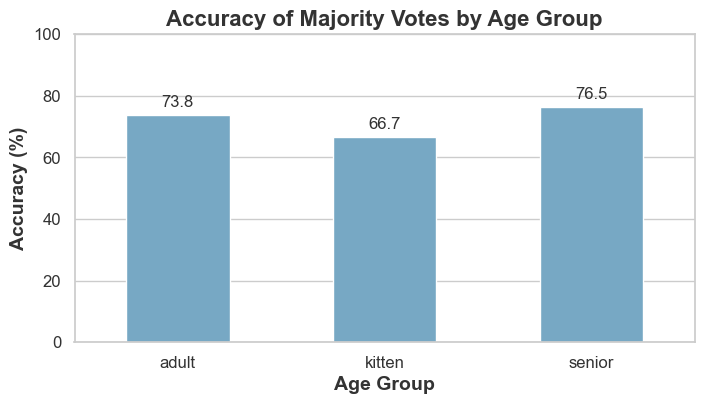

In [306]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [307]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  68.483412          422
1           kitten  75.229358          109
2           senior  70.261438          306


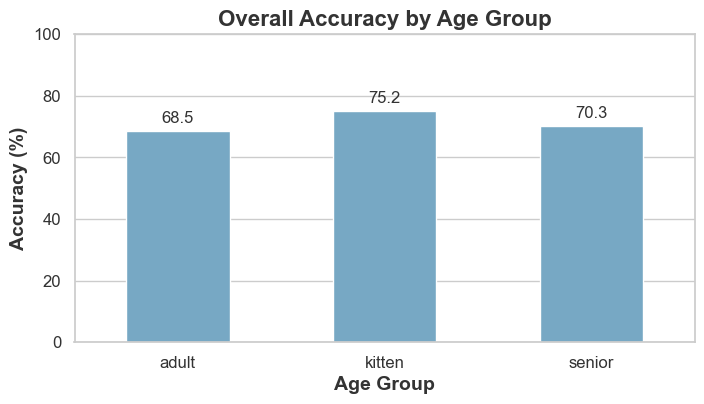

In [308]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [309]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    214      150     70.09
1          M    337      230     68.25
2          X    286      206     72.03


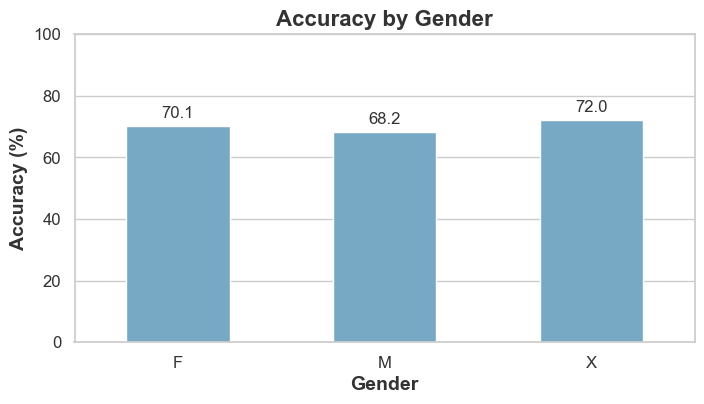

In [310]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [311]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7272727272727273, 0.7363636363636363, 0.7363636363636363]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.555035          427
1           kitten  80.882353          136
2           senior  67.320261          306,   actual_age_group   accuracy  total_count
0            adult  64.814815          432
1           kitten  81.739130          115
2           senior  72.875817          306,   actual_age_group   accuracy  total_count
0            adult  68.483412          422
1           kitten  75.229358          109
2           senior  70.261438          306]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    213      157     73.71
1          M    337      220     65.28
2          X    319      236     73.98,   all_gender  count  correct  accuracy
0          F    213      153     71.83
1          M    337      217     64.39
2          X    303      227     74.92,   al

# RANDOM SEED 4

In [312]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [313]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [314]:
tf.keras.backend.clear_session()

## Run Setup

In [315]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # Apply SMOTE to the training data only
    smote = SMOTE()
    X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
055A    20
067A    19
000B    19
029A    17
019A    17
101A    15
042A    14
059A    14
097B    14
106A    14
002A    13
051A    12
039A    12
036A    11
068A    11
040A    10
071A    10
005A    10
016A    10
014B    10
051B     9
072A     9
033A     9
065A     9
045A     9
010A     8
094A     8
013B     8
095A     8
050A     7
117A     7
027A     7
007A     6
108A     6
053A     6
008A     6
109A     6
023A     6
037A     6
044A     5
075A     5
070A     5
021A     5
025C     5
026A     4
105A     4
035A     4
104A     4
003A     4
062A     4
052A     4
058A     3
064A     3
056A     3
014A     3
012A     3
006A     3
102A     2
025B     2
032A     2
018A     2
054A     2
069A     2
087A     2
093A     2
011A     2
110A     1
100A     1
090A     1
019B     1
024A     1
076A     1
004A     1
048A     1
066A     1
026C     1
041A     1
092A     1
049A     1
043A     1
091A     1
026B     1
Name: cat_i

Epoch 1/1500
9/9 [==============================] - 0s 2ms/step - loss: 1.2944 - accuracy: 0.4949
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.8768 - accuracy: 0.6407
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.8188 - accuracy: 0.6787
Epoch 4/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.7296 - accuracy: 0.7057
Epoch 5/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.6819 - accuracy: 0.7317
Epoch 6/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.7437
Epoch 7/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6236 - accuracy: 0.7549
Epoch 8/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5970 - accuracy: 0.7734
Epoch 9/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5718 - accuracy: 0.7707
Epoch 10/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5889 - accuracy: 0.7623
Epoch 11/1500
9/9 [

Epoch 1/1500
9/9 [==============================] - 0s 1ms/step - loss: 1.4339 - accuracy: 0.4738
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.9073 - accuracy: 0.6345
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.7938 - accuracy: 0.6648
Epoch 4/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.7080 - accuracy: 0.7144
Epoch 5/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6456 - accuracy: 0.7493
Epoch 6/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6492 - accuracy: 0.7521
Epoch 7/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.7750
Epoch 8/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5718 - accuracy: 0.7805
Epoch 9/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5125 - accuracy: 0.8035
Epoch 10/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5387 - accuracy: 0.7860
Epoch 11/1500
9/9 [

Age group distribution: Counter({0: 373, 2: 228, 1: 159})
Epoch 1/1500
9/9 [==============================] - 0s 1ms/step - loss: 1.1111 - accuracy: 0.5639
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.9503 - accuracy: 0.6390
Epoch 3/1500
9/9 [==============================] - 0s 3ms/step - loss: 0.8465 - accuracy: 0.6640
Epoch 4/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.7980 - accuracy: 0.6979
Epoch 5/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.7627 - accuracy: 0.7113
Epoch 6/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6810 - accuracy: 0.7399
Epoch 7/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6647 - accuracy: 0.7399
Epoch 8/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6192 - accuracy: 0.7569
Epoch 9/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6049 - accuracy: 0.7694
Epoch 10/1500
9/9 [==============================] - 0s 2ms/

Epoch 1/1500
8/8 [==============================] - 1s 3ms/step - loss: 1.2563 - accuracy: 0.4933
Epoch 2/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.9774 - accuracy: 0.6182
Epoch 3/1500
8/8 [==============================] - 0s 3ms/step - loss: 0.8367 - accuracy: 0.6729
Epoch 4/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.8032 - accuracy: 0.6811
Epoch 5/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.7351 - accuracy: 0.7224
Epoch 6/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.7159 - accuracy: 0.7162
Epoch 7/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.7276
Epoch 8/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.7472
Epoch 9/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.6282 - accuracy: 0.7606
Epoch 10/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.7647
Epoch 11/1500
8/8 [

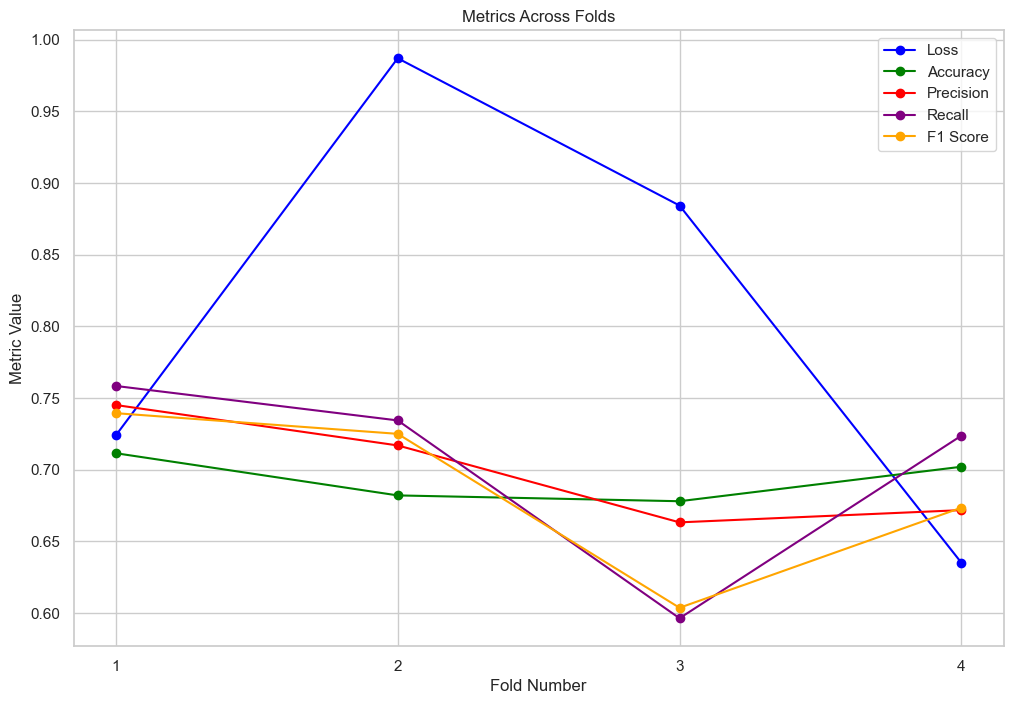

In [316]:
seed_4_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_4_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_4_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [317]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 845, Predictions: 845, Actuals: 845, Gender: 845


In [318]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [319]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.69 (76/110)


In [320]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [321]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, kitten, adult, senior, adult, adult, ...",adult,adult,True
62,056A,"[adult, senior, senior]",senior,senior,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, adult, adult, adult, sen...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,065A,"[adult, adult, kitten, adult, adult, senior, k...",adult,adult,True
70,064A,"[kitten, adult, adult]",adult,adult,True
69,063A,"[senior, kitten, adult, adult, adult, senior, ...",adult,adult,True
68,062A,"[adult, adult, adult, adult]",adult,adult,True


In [322]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  75.409836           61
1           kitten  86.666667           15
2           senior  50.000000           34


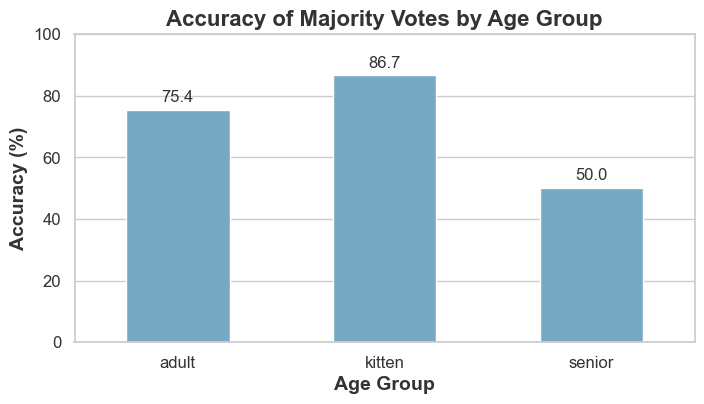

In [323]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [324]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  73.459716          422
1           kitten  82.905983          117
2           senior  58.823529          306


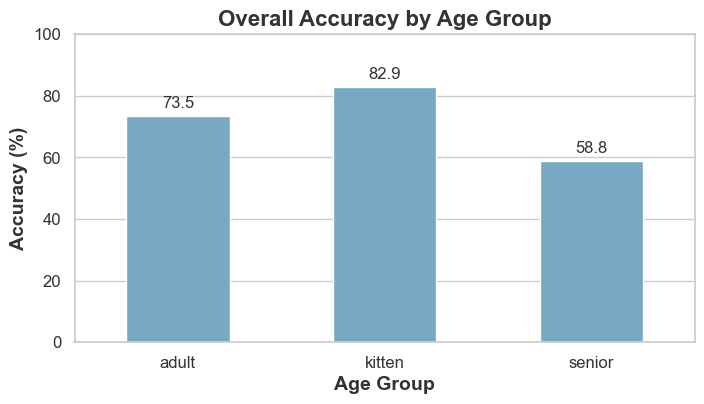

In [325]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [326]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      136     63.85
1          M    338      237     70.12
2          X    294      214     72.79


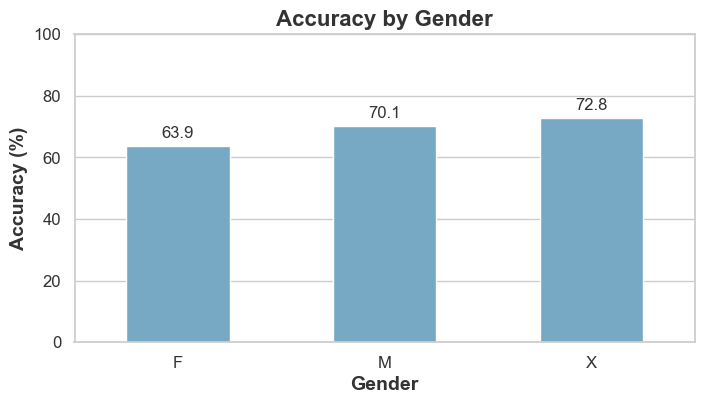

In [327]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [328]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7272727272727273, 0.7363636363636363, 0.7363636363636363, 0.6909090909090909]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.555035          427
1           kitten  80.882353          136
2           senior  67.320261          306,   actual_age_group   accuracy  total_count
0            adult  64.814815          432
1           kitten  81.739130          115
2           senior  72.875817          306,   actual_age_group   accuracy  total_count
0            adult  68.483412          422
1           kitten  75.229358          109
2           senior  70.261438          306,   actual_age_group   accuracy  total_count
0            adult  73.459716          422
1           kitten  82.905983          117
2           senior  58.823529          306]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    213      157     73.71
1          M    337      220     65.28
2       

# RANDOM SEED 5

In [329]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [330]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [331]:
tf.keras.backend.clear_session()

## Run Setup

In [332]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # Apply SMOTE to the training data only
    smote = SMOTE()
    X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)

outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
067A    19
029A    17
019A    17
101A    15
001A    14
106A    14
111A    13
028A    13
039A    12
116A    12
051A    12
063A    11
036A    11
068A    11
025A    11
040A    10
014B    10
071A    10
016A    10
005A    10
072A     9
022A     9
033A     9
015A     9
065A     9
045A     9
094A     8
095A     8
010A     8
117A     7
031A     7
027A     7
007A     6
108A     6
023A     6
008A     6
053A     6
037A     6
075A     5
070A     5
034A     5
044A     5
023B     5
021A     5
104A     4
026A     4
035A     4
009A     4
003A     4
052A     4
058A     3
006A     3
012A     3
056A     3
113A     3
014A     3
060A     3
102A     2
025B     2
069A     2
018A     2
054A     2
038A     2
087A     2
032A     2
092A     1
019B     1
090A     1
100A     1
091A     1
088A     1
073A     1
004A     1
048A     1
096A     1
043A     1
026C     1
026B     1
Name: cat_i

Epoch 1/1500
8/8 [==============================] - 0s 1ms/step - loss: 1.1537 - accuracy: 0.5711
Epoch 2/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.8241 - accuracy: 0.6890
Epoch 3/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7301 - accuracy: 0.7195
Epoch 4/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6483 - accuracy: 0.7500
Epoch 5/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6399 - accuracy: 0.7612
Epoch 6/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6410 - accuracy: 0.7541
Epoch 7/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.5673 - accuracy: 0.7835
Epoch 8/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.5115 - accuracy: 0.8069
Epoch 9/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.5381 - accuracy: 0.7866
Epoch 10/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.5172 - accuracy: 0.7967
Epoch 11/1500
8/8 [

Epoch 1/1500
9/9 [==============================] - 0s 1ms/step - loss: 1.1751 - accuracy: 0.5212
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.8187 - accuracy: 0.6667
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.7531 - accuracy: 0.7118
Epoch 4/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6914 - accuracy: 0.7290
Epoch 5/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6654 - accuracy: 0.7371
Epoch 6/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6643 - accuracy: 0.7416
Epoch 7/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6318 - accuracy: 0.7724
Epoch 8/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6152 - accuracy: 0.7633
Epoch 9/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5876 - accuracy: 0.7651
Epoch 10/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.5699 - accuracy: 0.7733
Epoch 11/1500
9/9 [

Epoch 1/1500
8/8 [==============================] - 0s 1ms/step - loss: 1.2044 - accuracy: 0.5111
Epoch 2/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.8245 - accuracy: 0.6586
Epoch 3/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.7769 - accuracy: 0.6838
Epoch 4/1500
8/8 [==============================] - 0s 2ms/step - loss: 0.7957 - accuracy: 0.6798
Epoch 5/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6941 - accuracy: 0.7202
Epoch 6/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6737 - accuracy: 0.7424
Epoch 7/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6662 - accuracy: 0.7394
Epoch 8/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6287 - accuracy: 0.7535
Epoch 9/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6149 - accuracy: 0.7515
Epoch 10/1500
8/8 [==============================] - 0s 1ms/step - loss: 0.6185 - accuracy: 0.7586
Epoch 11/1500
8/8 [

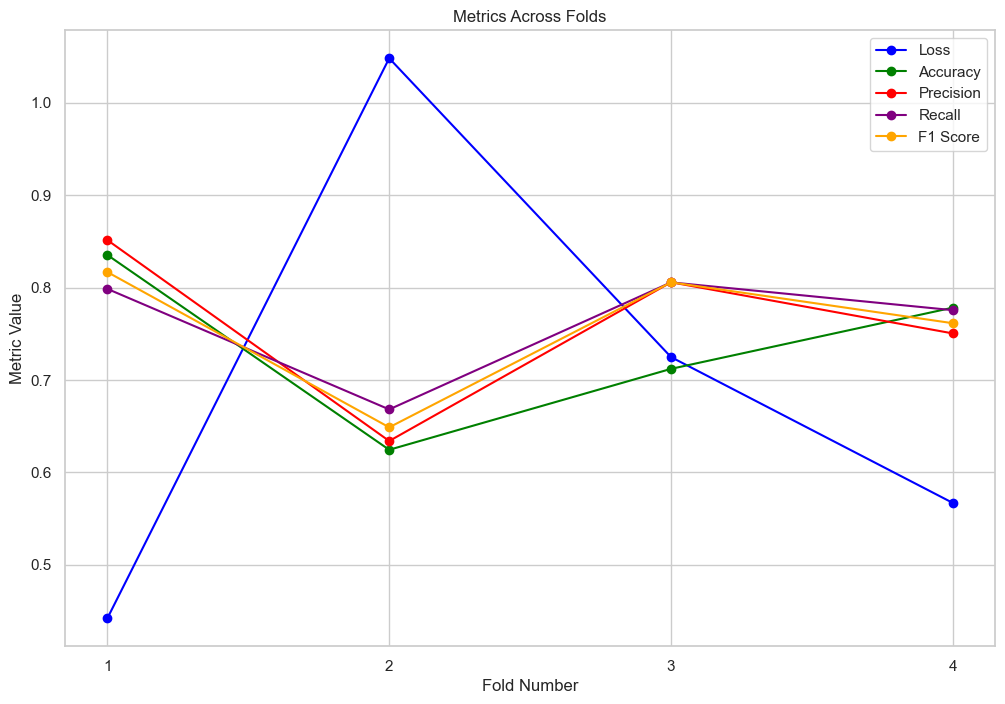

In [333]:
seed_5_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_5_training_acc_values = cv_training_acc_total

# Plotting all fold metrics|
seed_5_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [334]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 842, Predictions: 842, Actuals: 842, Gender: 842


In [335]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [336]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.76 (84/110)


In [337]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [338]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, kitten, adult, adult, adult, adult, a...",adult,adult,True
49,043A,[kitten],kitten,kitten,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, k...",adult,adult,True
70,064A,"[kitten, adult, adult]",adult,adult,True


In [339]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  77.049180           61
1           kitten  80.000000           15
2           senior  73.529412           34


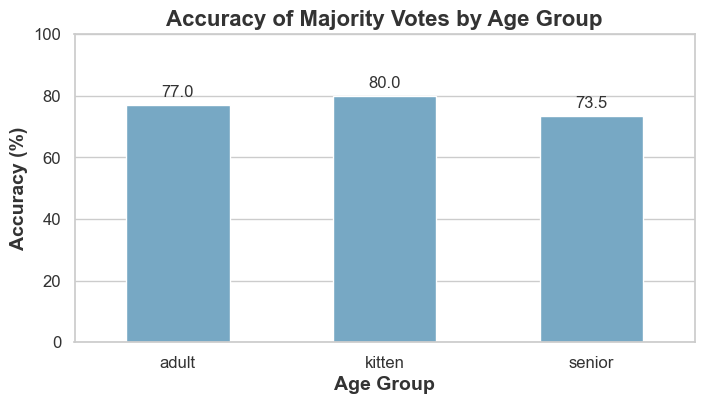

In [340]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


In [341]:
full_results

,cat_id,predicted_age_group,actual_age_group,all_gender,correct
0,093A,adult,senior,X,False
1,097A,senior,senior,X,True
2,097B,adult,adult,X,True
3,062A,adult,adult,X,True
4,062A,adult,adult,X,True
...,...,...,...,...,...
837,047A,kitten,kitten,X,True
838,047A,kitten,kitten,X,True
839,002B,adult,adult,M,True
840,027A,adult,adult,M,True


## Detailed Class Statistics

In [342]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  72.833724          427
1           kitten  80.733945          109
2           senior  70.588235          306


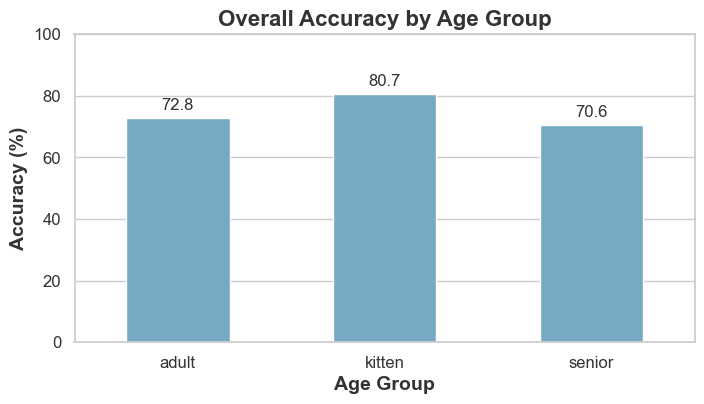

In [343]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [344]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      155     72.77
1          M    343      243     70.85
2          X    286      217     75.87


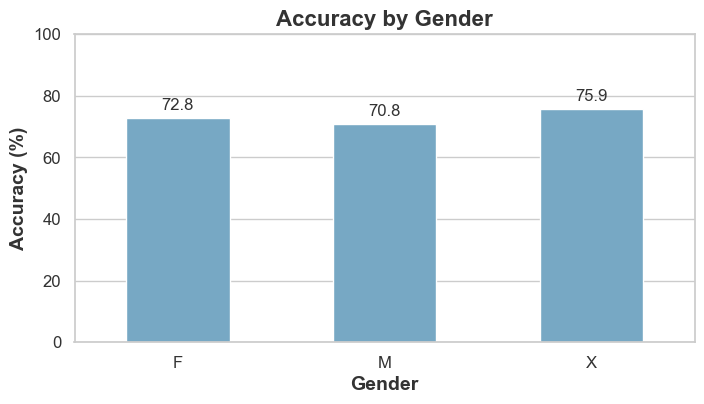

In [345]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [346]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats) 
print("Total Majority Vote Statistics so far:\n", all_majority_vote_details) 
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7272727272727273, 0.7363636363636363, 0.7363636363636363, 0.6909090909090909, 0.7636363636363637]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.555035          427
1           kitten  80.882353          136
2           senior  67.320261          306,   actual_age_group   accuracy  total_count
0            adult  64.814815          432
1           kitten  81.739130          115
2           senior  72.875817          306,   actual_age_group   accuracy  total_count
0            adult  68.483412          422
1           kitten  75.229358          109
2           senior  70.261438          306,   actual_age_group   accuracy  total_count
0            adult  73.459716          422
1           kitten  82.905983          117
2           senior  58.823529          306,   actual_age_group   accuracy  total_count
0            adult  72.833724          427
1           kitten  80.733945          109
2       

# --------------

# Total Final Results & Analysis

In [347]:
# Count unique cat_id per age group 
unique_cats_per_age_group = dataframe.groupby('age_group')['cat_id'].nunique()

# Display the counts
print("Unique cat_id counts in original dataframe:", unique_cats_per_age_group)

Unique cat_id counts in original dataframe: age_group
adult     62
kitten    16
senior    34
Name: cat_id, dtype: int64


## Metrics

In [348]:
# Calculate overall metrics
overall_avg_loss = np.mean(all_losses)
overall_avg_acc = np.mean(all_accuracies)
overall_avg_precision = np.mean(all_precisions)
overall_avg_recall = np.mean(all_recalls)
overall_avg_f1 = np.mean(all_f1)

print("Overall Average Metrics:")
print("Loss:", overall_avg_loss)
print("Accuracy:", overall_avg_acc)
print("Precision:", overall_avg_precision)
print("Recall:", overall_avg_recall)
print("F1 Score:", overall_avg_f1)

Overall Average Metrics:
Loss: 0.7887878820300103
Accuracy: 0.7050741732120513
Precision: 0.7109134836154306
Recall: 0.7157017839732636
F1 Score: 0.7045533996014111


## Majority Votes

In [349]:
# After calculating class_stats for each fold
all_majority_vote_details.append(class_stats)

# At the end, when calculating the final metrics:
total_majority_vote_details = pd.concat(all_majority_vote_details)

macro_avg_majority_vote_accuracy = (
    total_majority_vote_details.groupby('actual_age_group')['accuracy'].mean().mean()
)

print(f"Macro-Averaged Majority Vote Accuracy: {macro_avg_majority_vote_accuracy}")

# For class-wise accuracies:
macro_avg_class_accuracies = total_majority_vote_details.groupby('actual_age_group')['accuracy'].mean()

print("Macro-Averaged Class Accuracies:")
print(macro_avg_class_accuracies)

macro_avg_class_accuracies_df = macro_avg_class_accuracies.reset_index()
macro_avg_class_accuracies_df.columns = ['actual_age_group', 'accuracy']

Macro-Averaged Majority Vote Accuracy: 74.63159398549948
Macro-Averaged Class Accuracies:
actual_age_group
adult     75.136612
kitten    81.111111
senior    67.647059
Name: accuracy, dtype: float64


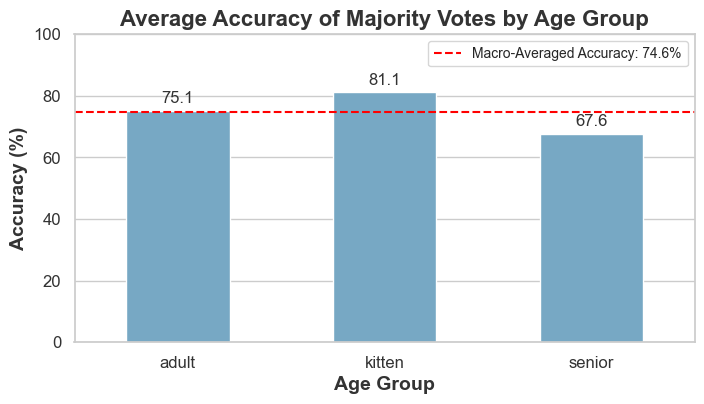

In [350]:
# Use the modified function
styled_barplot_with_average(macro_avg_class_accuracies_df, 'actual_age_group', 'accuracy', 
                            'Average Accuracy of Majority Votes by Age Group', 
                            'Age Group', 'Accuracy (%)', 
                            average_line=macro_avg_majority_vote_accuracy)

## Detailed Class Statistics

In [351]:
# Calculate the average class statistics across all folds and seeds
average_class_stats = pd.concat(all_class_stats).groupby('actual_age_group').agg({
    'accuracy': 'mean',
    'total_count': 'mean'
}).reset_index()
print("Average Class Statistics across all folds and seeds:")
print(average_class_stats)

# Calculate macro-averaged accuracy
macro_accuracy = average_class_stats['accuracy'].mean()
print(f"Macro-Averaged Accuracy: {macro_accuracy:.2f}%")

# Calculate macro-averaged accuracy for detailed class statistics
macro_avg_class_accuracy = average_class_stats['accuracy'].mean()

Average Class Statistics across all folds and seeds:
  actual_age_group   accuracy  total_count
0            adult  69.829340        426.0
1           kitten  80.298154        117.2
2           senior  67.973856        306.0
Macro-Averaged Accuracy: 72.70%


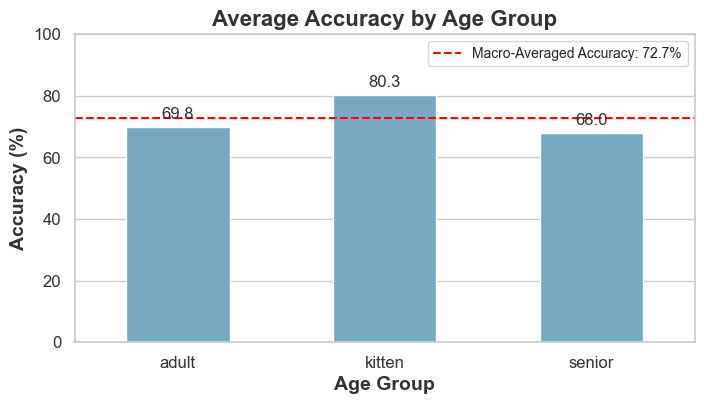

In [352]:
# Use the modified function for detailed class statistics
styled_barplot_with_average(average_class_stats, 'actual_age_group', 'accuracy', 
                            'Average Accuracy by Age Group', 
                            'Age Group', 'Accuracy (%)', 
                            average_line=macro_avg_class_accuracy)

In [353]:
# Concatenate all gender stats DataFrames and calculate the mean of accuracies
total_gender_stats = pd.concat(all_gender_stats)
average_gender_stats = total_gender_stats.groupby('all_gender').agg({
    'count': 'sum',  
    'correct': 'sum'  
}).reset_index()
average_gender_stats['accuracy'] = (average_gender_stats['correct'] / average_gender_stats['count']) * 100

print("Average Gender Accuracy:")
print(average_gender_stats)

Average Gender Accuracy:
  all_gender  count  correct   accuracy
0          F   1066      751  70.450281
1          M   1692     1147  67.789598
2          X   1488     1100  73.924731


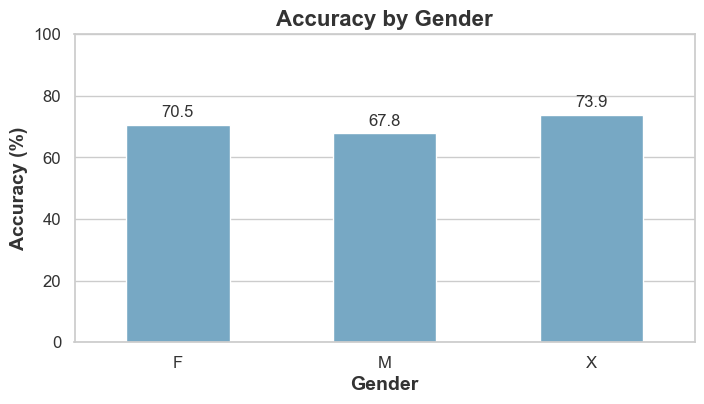

In [354]:
# Plot for Accuracy by Gender
styled_barplot(total_gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# Visualisations

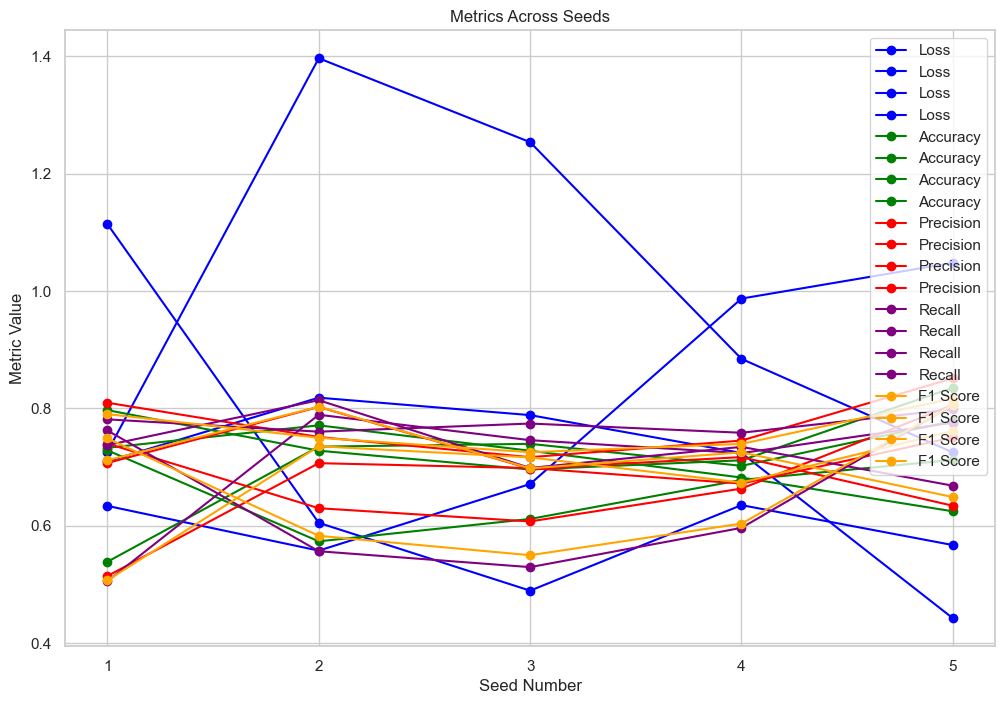

In [355]:
# Plotting all metrics
metrics_across_seeds = plot_all_metrics(all_losses, all_accuracies, all_precisions, all_recalls, all_f1, "Seeds", "Seed Number")

## Display the seed folds results together

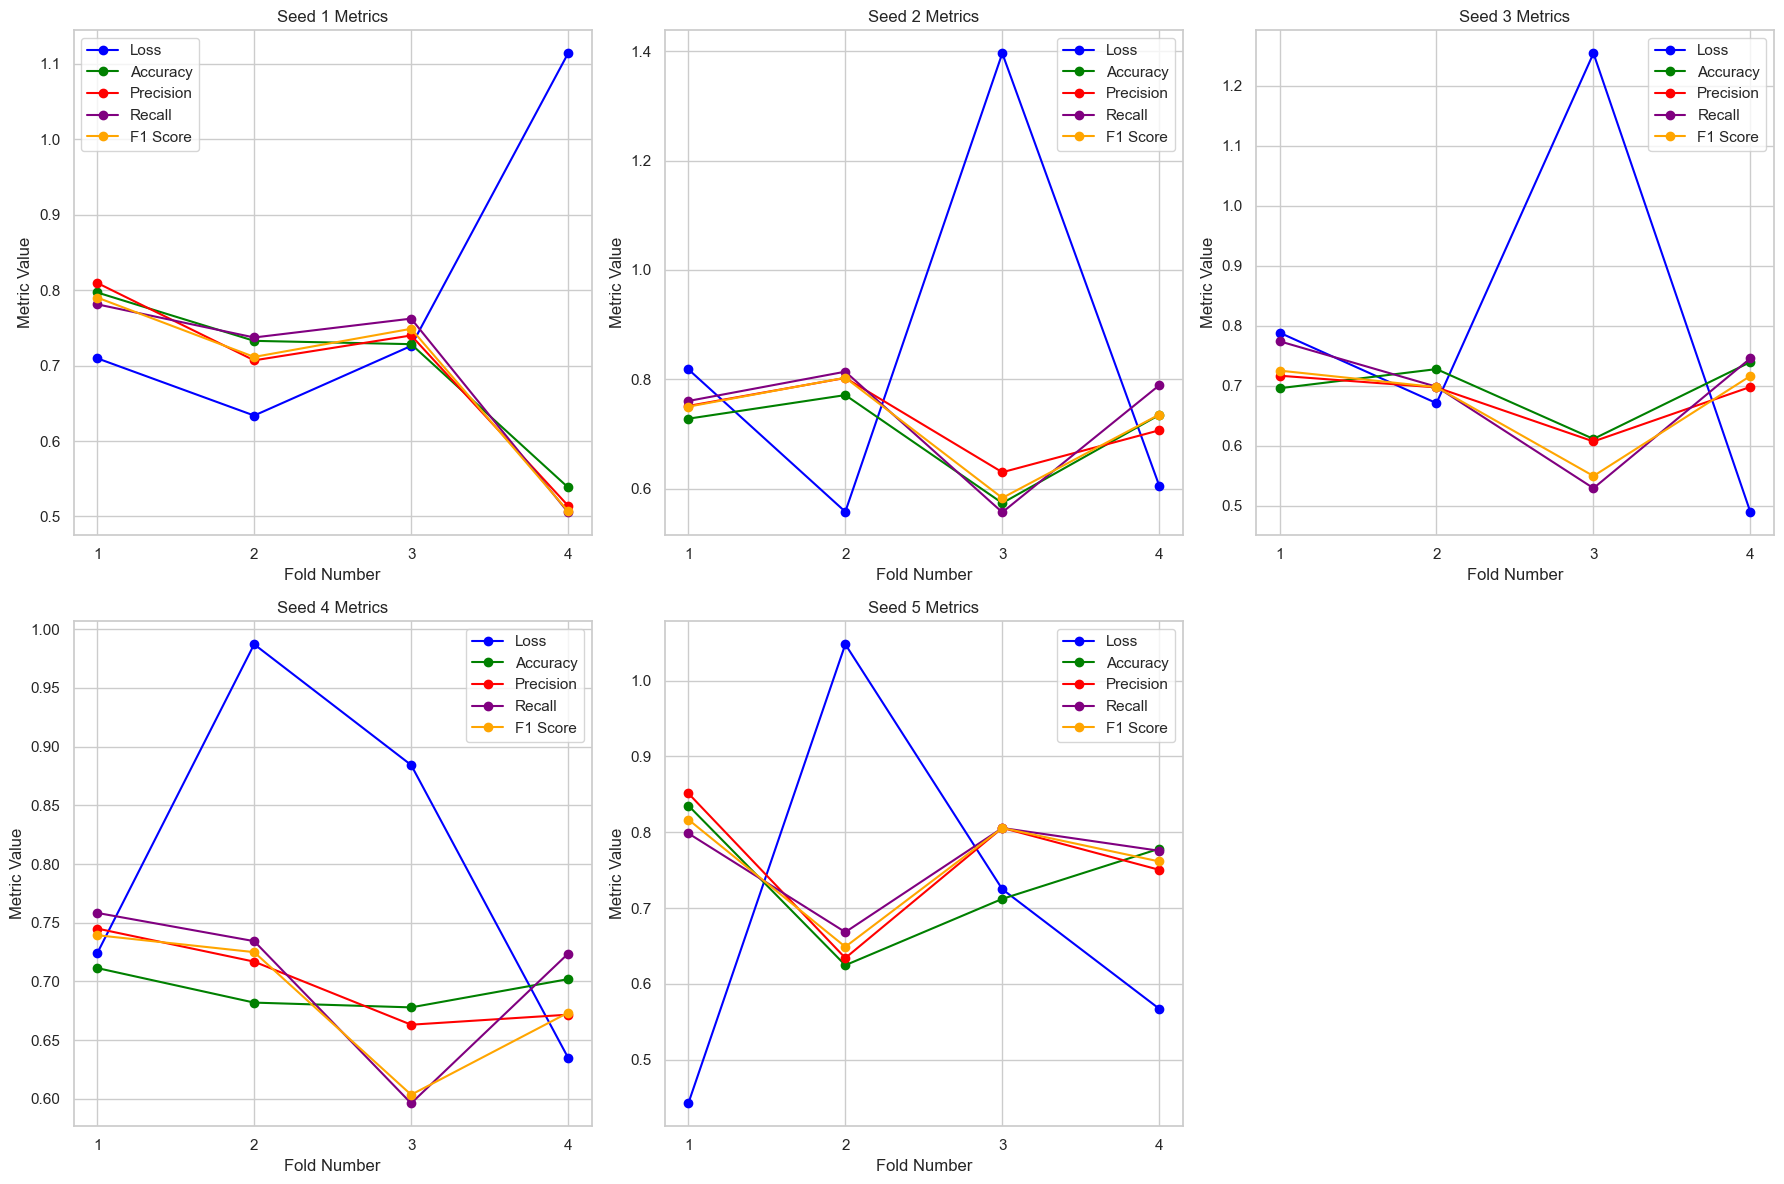

In [356]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

def plot_metrics_on_axes(ax, losses, accuracies, precisions, recalls, f1, title):
    ax.plot(range(1, len(losses)+1), losses, marker='o', color='blue', label='Loss')
    ax.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(range(1, len(precisions)+1), precisions, marker='o', color='red', label='Precision')
    ax.plot(range(1, len(recalls)+1), recalls, marker='o', color='purple', label='Recall')
    ax.plot(range(1, len(f1)+1), f1, marker='o', color='orange', label='F1 Score')
    ax.set_xticks([1, 2, 3, 4])  # Set x-axis ticks to full integers
    ax.set_title(title)
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True)

# Plot onto each axes object
plot_metrics_on_axes(axes[0], *seed_1_folds_values, "Seed 1 Metrics")
plot_metrics_on_axes(axes[1], *seed_2_folds_values, "Seed 2 Metrics")
plot_metrics_on_axes(axes[2], *seed_3_folds_values, "Seed 3 Metrics")
plot_metrics_on_axes(axes[3], *seed_4_folds_values, "Seed 4 Metrics")
plot_metrics_on_axes(axes[4], *seed_5_folds_values, "Seed 5 Metrics")

# Hide the unused subplot 
for ax in axes[5:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics

In [357]:
# Calculate the standard deviation for each metric
std_loss = np.std(all_losses)
std_accuracy = np.std(all_accuracies)
std_precision = np.std(all_precisions)
std_recall = np.std(all_recalls)
std_f1 = np.std(all_f1)

print("Standard Deviations:")
print(f"Loss: {std_loss}")
print(f"Accuracy: {std_accuracy}")
print(f"Precision: {std_precision}")
print(f"Recall: {std_recall}")
print(f"F1 Score: {std_f1}")

Standard Deviations:
Loss: 0.2484380620140429
Accuracy: 0.07117383927271939
Precision: 0.07688510601572236
Recall: 0.09222268490124902
F1 Score: 0.08439599309904552


In [358]:
# Calculate the interquartile range for each metric
iqr_loss = np.percentile(all_losses, 75) - np.percentile(all_losses, 25)
iqr_accuracy = np.percentile(all_accuracies, 75) - np.percentile(all_accuracies, 25)
iqr_precision = np.percentile(all_precisions, 75) - np.percentile(all_precisions, 25)
iqr_recall = np.percentile(all_recalls, 75) - np.percentile(all_recalls, 25)
iqr_f1 = np.percentile(all_f1, 75) - np.percentile(all_f1, 25)

print("Interquartile Ranges:")
print(f"Loss: {iqr_loss}")
print(f"Accuracy: {iqr_accuracy}")
print(f"Precision: {iqr_precision}")
print(f"Recall: {iqr_recall}")
print(f"F1 Score: {iqr_f1}")


Interquartile Ranges:
Loss: 0.28348711133003235
Accuracy: 0.05488210916519165
Precision: 0.08095062883121917
Recall: 0.08615123411950076
F1 Score: 0.08543777517127693


### Variation

In [359]:
# Calculate the variation for each metric
var_loss = np.var(all_losses)
var_accuracy = np.var(all_accuracies)
var_precision = np.var(all_precisions)
var_recall = np.var(all_recalls)
var_f1 = np.var(all_f1)

print("Variations:")
print(f"Loss: {var_loss}")
print(f"Accuracy: {var_accuracy}")
print(f"Precision: {var_precision}")
print(f"Recall: {var_recall}")
print(f"F1 Score: {var_f1}")

Variations:
Loss: 0.06172147065729343
Accuracy: 0.005065715396818894
Precision: 0.005911319527048866
Recall: 0.008505023610395065
F1 Score: 0.00712268365117414


### Levene tests for variation significance between seeds

#### Levene across seeds for LOSS

In [360]:
# Levene across seeds for LOSS
stat_val, p_val = levene(seed_1_folds_values[0], seed_2_folds_values[0], seed_3_folds_values[0], seed_4_folds_values[0], seed_5_folds_values[0])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.38, P-value: 0.819


#### Levene across seeds for ACCURACY

In [361]:
# Levene across seeds for ACCURACY
stat_val, p_val = levene(seed_1_folds_values[1], seed_2_folds_values[1], seed_3_folds_values[1], seed_4_folds_values[1], seed_5_folds_values[1])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.60, P-value: 0.667


#### Levene across seeds for PRECISION

In [362]:
# Levene across seeds for PRECISION
stat_val, p_val = levene(seed_1_folds_values[2], seed_2_folds_values[2], seed_3_folds_values[2], seed_4_folds_values[2], seed_5_folds_values[2])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.74, P-value: 0.581


#### Levene across seeds for RECALL

In [363]:
# Levene across seeds for RECALL
stat_val, p_val = levene(seed_1_folds_values[3], seed_2_folds_values[3], seed_3_folds_values[3], seed_4_folds_values[3], seed_5_folds_values[3])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.17, P-value: 0.950


#### Levene across seeds for F1

In [364]:
# Levene across seeds for F1
stat_val, p_val = levene(seed_1_folds_values[4], seed_2_folds_values[4], seed_3_folds_values[4], seed_4_folds_values[4], seed_5_folds_values[4])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.15, P-value: 0.959


## Print out measurements for future further analysis (without rerunning notebook)

In [365]:
seed_1_folds_values

[[0.7096837162971497,
  0.6337435245513916,
  0.7260684370994568,
  1.1140722036361694],
 [0.796954333782196,
  0.7327935099601746,
  0.7283950448036194,
  0.5384615659713745],
 [0.8095813204508856,
  0.7069310344827585,
  0.739936209501427,
  0.5141740658527563],
 [0.7812474735225159,
  0.7372598935431612,
  0.7622689155708025,
  0.5054768175927088],
 [0.7902088333122815,
  0.7114852175259928,
  0.7487897723191841,
  0.5068627450980393]]

In [366]:
seed_2_folds_values

[[0.8181975483894348,
  0.5574815273284912,
  1.396707534790039,
  0.604875385761261],
 [0.7278106212615967,
  0.7710280418395996,
  0.5733333230018616,
  0.7346938848495483],
 [0.7511552643656333,
  0.8024220961421985,
  0.6297541238717709,
  0.7065652993870816],
 [0.760227707382179,
  0.8138888888888888,
  0.5564499484004127,
  0.7890568975761673],
 [0.7498159778272463,
  0.8027998330440062,
  0.5827509257215723,
  0.7353601599769525]]

In [367]:
seed_3_folds_values

[[0.7884541153907776,
  0.6710030436515808,
  1.2536909580230713,
  0.48925915360450745],
 [0.6958333253860474,
  0.7277227640151978,
  0.6114649772644043,
  0.7394958138465881],
 [0.7167499167499168,
  0.6972437553832903,
  0.6072457505041774,
  0.6981235504954669],
 [0.774103325761547, 0.69836293974225, 0.5293648191749702, 0.7457272504958835],
 [0.72523139763, 0.6976724615387626, 0.5496755429339699, 0.7163680915904785]]

In [368]:
seed_4_folds_values

[[0.7239758372306824,
  0.9870988130569458,
  0.8843185305595398,
  0.6350687742233276],
 [0.7114624381065369,
  0.6820276379585266,
  0.6779661178588867,
  0.7020202279090881],
 [0.745095539235686,
  0.7169011082693947,
  0.6632175412663218,
  0.6717563127757439],
 [0.7583986970125585,
  0.7343522879481146,
  0.5963012083701739,
  0.7237132696986711],
 [0.7394109396914446,
  0.724987974987975,
  0.6036098691836397,
  0.6734446865165818]]

# Training Accuracy Analysis

In [369]:
all_best_training_acc

[0.9288194179534912,
 0.923901379108429,
 0.9166666865348816,
 0.929097592830658,
 0.893782377243042,
 0.927450954914093,
 0.9487895965576172,
 0.9002057909965515,
 0.8440545797348022,
 0.9079457521438599,
 0.925574004650116,
 0.8885316252708435,
 0.9442896842956543,
 0.9182736277580261,
 0.9338695406913757,
 0.8978328108787537,
 0.8696027398109436,
 0.9390243887901306,
 0.9295393228530884,
 0.931313157081604]

In [370]:
total_training_acc

[[0.5277777910232544,
  0.6675347089767456,
  0.7161458134651184,
  0.7256944179534912,
  0.7543402910232544,
  0.7387152910232544,
  0.7777777910232544,
  0.75,
  0.7708333134651184,
  0.7821180820465088,
  0.7855902910232544,
  0.8090277910232544,
  0.7821180820465088,
  0.7873263955116272,
  0.8072916865348816,
  0.8090277910232544,
  0.8046875,
  0.8289930820465088,
  0.8220486044883728,
  0.8298611044883728,
  0.8263888955116272,
  0.8029513955116272,
  0.8272569179534912,
  0.8229166865348816,
  0.8359375,
  0.8446180820465088,
  0.8255208134651184,
  0.8237847089767456,
  0.828125,
  0.8272569179534912,
  0.8515625,
  0.8480902910232544,
  0.8619791865348816,
  0.8428819179534912,
  0.8559027910232544,
  0.8506944179534912,
  0.8498263955116272,
  0.8680555820465088,
  0.8619791865348816,
  0.8559027910232544,
  0.8515625,
  0.8454861044883728,
  0.859375,
  0.8585069179534912,
  0.8741319179534912,
  0.8715277910232544,
  0.8697916865348816,
  0.8741319179534912,
  0.8732638955

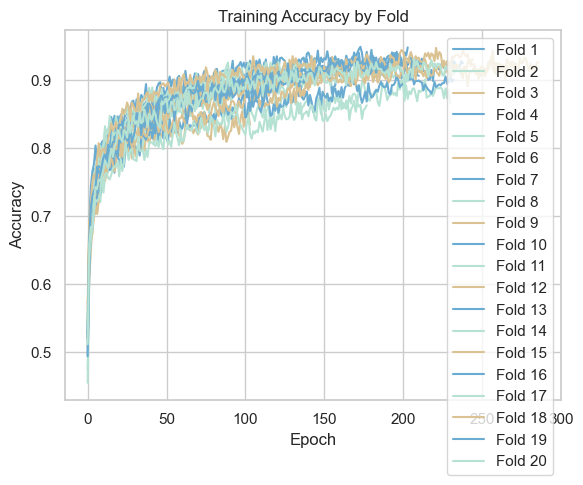

In [371]:
# Plot accuracy histories for all folds
for i, fold_accuracy in enumerate(total_training_acc):
    plt.plot(fold_accuracy, label=f'Fold {i+1}')

plt.title('Training Accuracy by Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [372]:
# running time including analysis
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 65.92354822158813 seconds
